# DEEP LEARNING:
# Classification and Regression MVA

In [39]:
# Needed scripts and libraries
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches

import keras
from keras.layers import Dense
from keras.models import Sequential
from keras import utils as np_utils
from keras.utils import to_categorical
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dropout

from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

## Getting Started

Below are the functions provided with the assignment on [the class website](http://www.labri.fr/perso/vlepetit/teaching/deep_learning_mva/mp1.py). To understand it, let's show the code in the notebook directly.

The *generate_a_drawing* function and its override versions will be used to create the images.

In [2]:
def generate_a_drawing(figsize, U, V, noise=0.0):
    fig = plt.figure(figsize=(figsize,figsize))
    ax = plt.subplot(111)
    plt.axis('Off')
    ax.set_xlim(0,figsize)
    ax.set_ylim(0,figsize)
    ax.fill(U, V, "k")
    fig.canvas.draw()
    imdata = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)[::3].astype(np.float32)
    imdata = imdata + noise * np.random.random(imdata.size)
    plt.close(fig)
    return imdata

In [3]:
def generate_a_rectangle(noise=0.0, free_location=False):
    figsize = 1.0    
    U = np.zeros(4)
    V = np.zeros(4)
    if free_location:
        corners = np.random.random(4)
        top = max(corners[0], corners[1])
        bottom = min(corners[0], corners[1])
        left = min(corners[2], corners[3])
        right = max(corners[2], corners[3])
    else:
        side = (0.3 + 0.7 * np.random.random()) * figsize
        top = figsize/2 + side/2
        bottom = figsize/2 - side/2
        left = bottom
        right = top
    U[0] = U[1] = top
    U[2] = U[3] = bottom
    V[0] = V[3] = left
    V[1] = V[2] = right
    return generate_a_drawing(figsize, U, V, noise)

In [4]:
def generate_a_disk(noise=0.0, free_location=False):
    figsize = 1.0
    if free_location:
        center = np.random.random(2)
    else:
        center = (figsize/2, figsize/2)
    radius = (0.3 + 0.7 * np.random.random()) * figsize/2
    N = 50
    U = np.zeros(N)
    V = np.zeros(N)
    i = 0
    for t in np.linspace(0, 2*np.pi, N):
        U[i] = center[0] + np.cos(t) * radius
        V[i] = center[1] + np.sin(t) * radius
        i = i + 1
    return generate_a_drawing(figsize, U, V, noise)

In [5]:
def generate_a_triangle(noise=0.0, free_location=False):
    figsize = 1.0
    if free_location:
        U = np.random.random(3)
        V = np.random.random(3)
    else:
        size = (0.3 + 0.7 * np.random.random())*figsize/2
        middle = figsize/2
        U = (middle, middle+size, middle-size)
        V = (middle+size, middle-size, middle-size)
    imdata = generate_a_drawing(figsize, U, V, noise)
    return [imdata, [U[0], V[0], U[1], V[1], U[2], V[2]]]

Let's visualize the shapes created by the different functions defined above.

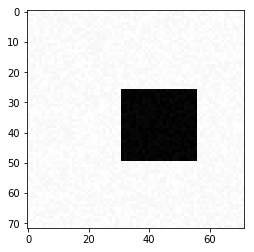

In [6]:
im = generate_a_rectangle(10, True)
plt.imshow(im.reshape(72,72), cmap='gray')

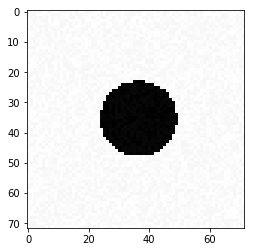

In [7]:
im = generate_a_disk(10)
plt.imshow(im.reshape(72,72), cmap='gray')

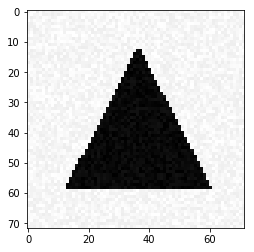

In [8]:
[im, v] = generate_a_triangle(20, False)
plt.imshow(im.reshape(72,72), cmap='gray')

Here, the function will create a batch of images, randomly distributed between the 3 different shapes, for the given size *nb_samples*. We put the print in comment to avoid big output cells during dataset generations.

In [9]:
def generate_dataset_classification(nb_samples, noise=0.0, free_location=False):
    # Getting im_size:
    im_size = generate_a_rectangle().shape[0]
    X = np.zeros([nb_samples,im_size])
    Y = np.zeros(nb_samples)
    #print('Creating data:')
    for i in range(nb_samples):
        #if i % 10 == 0:
            #print(i)
        category = np.random.randint(3)
        if category == 0:
            X[i] = generate_a_rectangle(noise, free_location)
        elif category == 1: 
            X[i] = generate_a_disk(noise, free_location)
        else:
            [X[i], V] = generate_a_triangle(noise, free_location)
        Y[i] = category
    X = (X + noise) / (255 + 2 * noise)
    return [X, Y]

Using the previously defined *generate_dataset_classification*, we define a dataset and change Y to a categorical variable.

In [10]:
def generate_test_set_classification():
    np.random.seed(42)
    [X_test, Y_test] = generate_dataset_classification(300, 20, True)
    Y_test = np_utils.to_categorical(Y_test, 3) 
    return [X_test, Y_test]

In [11]:
def generate_dataset_regression(nb_samples, noise=0.0):
    # Getting im_size:
    im_size = generate_a_triangle()[0].shape[0]
    X = np.zeros([nb_samples,im_size])
    Y = np.zeros([nb_samples, 6])
    #print('Creating data:')
    for i in range(nb_samples):
        #if i % 10 == 0:
            #print(i)
        [X[i], Y[i]] = generate_a_triangle(noise, True)
    X = (X + noise) / (255 + 2 * noise)
    return [X, Y]

In [12]:
def visualize_prediction(x, y):
    fig, ax = plt.subplots(figsize=(5, 5))
    I = x.reshape((72,72))
    ax.imshow(I, extent=[-0.15,1.15,-0.15,1.15],cmap='gray')
    ax.set_xlim([0,1])
    ax.set_ylim([0,1])

    xy = y.reshape(3,2)
    tri = patches.Polygon(xy, closed=True, fill = False, edgecolor = 'r', linewidth = 5, alpha = 0.5)
    ax.add_patch(tri)

    plt.show()

In [13]:
def generate_test_set_regression():
    np.random.seed(42)
    [X_test, Y_test] = generate_dataset_regression(300, 20)
    Y_test = np_utils.to_categorical(Y_test, 3) 
    return [X_test, Y_test]

## Simple Classification

### Dataset creation

To start with, we create a dataset of 300 images using a noise value of 20. We then take a look at the first picture of the dataset.

In [14]:
[X_train, Y_train] = generate_dataset_classification(300, 20)

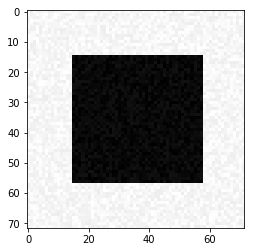

In [15]:
plt.imshow(X_train[0].reshape(72,72), cmap='gray')

In [16]:
pd.DataFrame(X_train).head(5)

,0,1,2,3,4,5,6,7,8,9,...,5174,5175,5176,5177,5178,5179,5180,5181,5182,5183
0,0.987747,0.941106,0.988499,0.957752,0.959526,0.965842,0.964331,0.933111,0.942705,0.955867,...,0.992354,0.985252,0.981225,0.996744,0.962813,0.957923,0.993972,0.974191,0.977193,0.944912
1,0.969299,0.957746,0.936073,0.983163,0.946706,0.995078,0.982326,0.987505,0.946041,0.983158,...,0.937172,0.995964,0.992786,0.969239,0.995164,0.934560,0.969714,0.946293,0.967159,0.982506
2,0.960829,0.933502,0.939873,0.985055,0.949612,0.986906,0.957401,0.989048,0.954655,0.982930,...,0.932468,0.974295,0.941511,0.982963,0.962446,0.962657,0.937847,0.950871,0.951969,0.977733
3,0.998203,0.975692,0.974681,0.949810,0.991913,0.998395,0.987455,0.951305,0.979531,0.963025,...,0.992938,0.982573,0.979172,0.989449,0.951238,0.986328,0.946350,0.991549,0.946908,0.969099
4,0.966522,0.942526,0.986190,0.960527,0.970561,0.939751,0.988877,0.938321,0.939700,0.938118,...,0.934105,0.954954,0.997993,0.946294,0.964764,0.981640,0.997106,0.941282,0.937399,0.933720


In [17]:
pd.DataFrame(Y_train).head(5)

,0
0,0.0
1,1.0
2,2.0
3,0.0
4,2.0


- X is our list of vectors of images. Each image vector being composed of 255 gray shades values, for the 255 pixels.
- Y is the list of the images categories (0= rectangle, 1= disk, 2= triangle)

### Classifier 

We first proceed to one hot encoding of our Y_train using the keras *to_categorical* function. We then obtain Y as 3 columns indicating if a picture is, or not, of category 1,2,3.

In [18]:
target = to_categorical(Y_train)
pd.DataFrame(target).head(5)

,0,1,2
0,1.0,0.0,0.0
1,0.0,1.0,0.0
2,0.0,0.0,1.0
3,1.0,0.0,0.0
4,0.0,0.0,1.0


Time to construct our neural network!
- The **hidden layers** use a **rectifier activation (*RELU*) function**. It can speed up the training process.
- The **output layer** must have **3 output values**, one for each class of the one hot encoded *target*. The highest value output is our prediction.
- The **output layer** uses the **“softmax” activation function**. So our output values are in the range [0,1] as predicted probabilities.

In [19]:
# Define the input_shape
n_cols = X_train.shape[1]

# Set up the model
model = Sequential()

# Add layers
model.add(Dense(50,activation = 'relu', input_shape = (n_cols,)))
model.add(Dense(50,activation = 'relu'))
model.add(Dense(3,activation = 'softmax'))

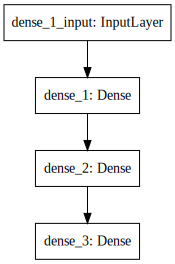

In [41]:
SVG(model_to_dot(model).create(prog='dot', format='svg'))

Now, we compile our classifier using first a **Stochastic Gradient Descent** optimization. For a multi class classification like here, a **categorical crossentropy** loss function is usually a go-to option. We also add the *accuracy* metrics option to provide simpler interpretation of our model progress accross epochs. 

In [20]:
# Compile the model
model.compile(optimizer='sgd', loss='categorical_crossentropy', metrics=['accuracy'])

# Fit the model
model.fit(X_train, target, epochs=100)

Epoch 1/100
300/300 [==============================] - 0s 1ms/step - loss: 1.1803 - acc: 0.3133
Epoch 2/100
300/300 [==============================] - 0s 153us/step - loss: 1.0414 - acc: 0.4367
Epoch 3/100
300/300 [==============================] - 0s 155us/step - loss: 1.0225 - acc: 0.4800
Epoch 4/100
300/300 [==============================] - 0s 138us/step - loss: 1.0005 - acc: 0.5633
Epoch 5/100
300/300 [==============================] - 0s 169us/step - loss: 0.8099 - acc: 0.6367
Epoch 6/100
300/300 [==============================] - 0s 214us/step - loss: 0.9566 - acc: 0.5400

On this simple classification, we already have an accuracy of 1 using SGD!  Let's try the **adam** optimizer and see if we can observe any difference. For that, we define another model using the exact same code as the previous cells. We define the **batch_size** to 32 and we also  reduce the number of epochs.

In [21]:
model_2 = Sequential()
model_2.add(Dense(50,activation = 'relu', input_shape = (n_cols,)))
model_2.add(Dense(50,activation = 'relu'))
model_2.add(Dense(3,activation = 'softmax'))

model_2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model_2.fit(X_train, target, epochs=20, batch_size=32)

Epoch 1/20
300/300 [==============================] - 0s 1ms/step - loss: 1.7399 - acc: 0.3233
Epoch 2/20
300/300 [==============================] - 0s 144us/step - loss: 0.9694 - acc: 0.5967
Epoch 3/20
300/300 [==============================] - 0s 151us/step - loss: 0.6731 - acc: 0.6867
Epoch 4/20
300/300 [==============================] - 0s 150us/step - loss: 0.5226 - acc: 0.7800
Epoch 5/20
300/300 [==============================] - 0s 150us/step - loss: 0.4700 - acc: 0.7567
Epoch 6/20
300/300 [==============================] - 0s 153us/step - loss: 0.4142 - acc: 0.8233

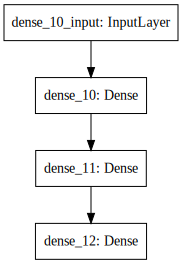

In [42]:
SVG(model_to_dot(model_2).create(prog='dot', format='svg'))

We arrive to a 1 accuracy even faster. We can check our classifiers with a newly generated image:

In [22]:
X_test = generate_a_disk()
X_test = X_test.reshape(1, X_test.shape[0])

print(model.predict(X_test))
print(model_2.predict(X_test))

[[ 0.  1.  0.]]
[[ 0.  1.  0.]]


Both models correctly predict the category 1 (a disk).

### Vizualisation of the Solution

/Users/canard/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:2: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  from ipykernel import kernelapp as app


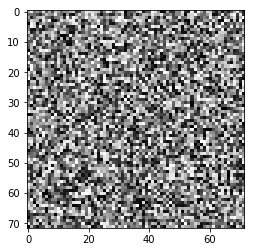

In [23]:
weights = pd.DataFrame(model.get_weights()[0])
plt.imshow(weights[0].reshape(72,72), cmap='gray')

/Users/canard/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:1: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  if __name__ == '__main__':


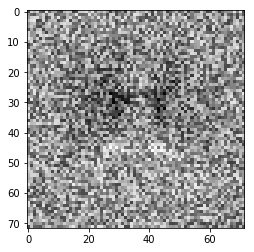

In [24]:
plt.imshow(weights[1].reshape(72,72), cmap='gray')

/Users/canard/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:1: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  if __name__ == '__main__':


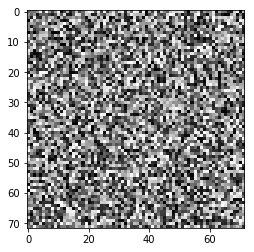

In [25]:
plt.imshow(weights[2].reshape(72,72), cmap='gray')

### A More Difficult Classification Problem

Let's now make things a bit more complex, by generating a dataset composed of shapes of different sizes and positions. We use the same function as previously but with the parameter *free_location* to True.

In [228]:
[X_train, Y_train] = generate_dataset_classification(300, 20, True)

We retrain the previous classifier on the new dataset to compare performance.

In [229]:
target = to_categorical(Y_train)

model_2 = Sequential()
model_2.add(Dense(50,activation = 'relu', input_shape = (n_cols,)))
model_2.add(Dense(50,activation = 'relu'))
model_2.add(Dense(3,activation = 'softmax'))

model_2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model_2.fit(X_train, target, epochs=20, batch_size=32)

Epoch 1/20
300/300 [==============================] - 1s 2ms/step - loss: 1.8306 - acc: 0.3500
Epoch 2/20
300/300 [==============================] - 0s 230us/step - loss: 1.1541 - acc: 0.3767
Epoch 3/20
300/300 [==============================] - 0s 218us/step - loss: 1.0649 - acc: 0.4300
Epoch 4/20
300/300 [==============================] - 0s 192us/step - loss: 0.9851 - acc: 0.5267
Epoch 5/20
300/300 [==============================] - 0s 175us/step - loss: 0.9676 - acc: 0.5000

For the **same number of epochs** with the **adam optimizer**, performance is way worse than on the previous dataset.

In [230]:
model_2 = Sequential()
model_2.add(Dense(50,activation = 'relu', input_shape = (n_cols,)))
model_2.add(Dense(50,activation = 'relu'))
model_2.add(Dense(3,activation = 'softmax'))

model_2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model_2.fit(X_train, target, epochs=100, batch_size=32)

Epoch 1/100
300/300 [==============================] - 1s 5ms/step - loss: 1.7006 - acc: 0.3367
Epoch 2/100
300/300 [==============================] - 0s 209us/step - loss: 1.1065 - acc: 0.3700
Epoch 3/100
300/300 [==============================] - 0s 178us/step - loss: 1.0530 - acc: 0.4367
Epoch 4/100
300/300 [==============================] - 0s 196us/step - loss: 1.0673 - acc: 0.4267
Epoch 5/100
300/300 [==============================] - 0s 225us/step - loss: 0.9792 - acc: 0.5100

We still get close to **0.85 accuracy with a 100 epochs**. We can **test** that classifier again on a newly defined test set:

In [29]:
[X_test, Y_test] = generate_test_set_classification()

In [30]:
model.evaluate(X_test, Y_test)

300/300 [==============================] - 0s 264us/step


[2.8695595963795979, 0.34333333333333332]

Now, we want to tackle this classification with a more elaborated and suited model for image classification. We create a new **convolutional network**.

In [31]:
# Reformat the input
predictors = X_train.reshape(X_train.shape[0], 72, 72, 1)
predictors /= np.max(X_train)
print(predictors.shape)

(300, 72, 72, 1)


For the topology of our new model, we use:
- **2 Convolutional layers (2D for images) with 16 5x5 filters**. We also tried with only one layer and the performance was 2 times lower. The input shape is our 72x72 image size, with the third dimension as 1 for the single channel.
- One **2x2 pooling layer** to reduce the overall inputs/images size.
- **1 fully connected layer** once we flatten the pooling layer output.
- ** 2 dropout layers** after the pooling and dense layers, to prevent overfitting.
- Our **output layer has 3 nodes** for the 3 categories of images.

In [32]:
model_3 = Sequential()

model_3.add(Conv2D(16, (5,5), activation='relu', input_shape=(72, 72, 1)))
model_3.add(Conv2D(16, (5,5), activation='relu'))
model_3.add(MaxPooling2D(pool_size=(2, 2))) 
model_3.add(Dropout(0.25))
model_3.add(Flatten())
model_3.add(Dense(50, activation='relu'))
model_3.add(Dropout(0.5))
model_3.add(Dense(3, activation='softmax'))

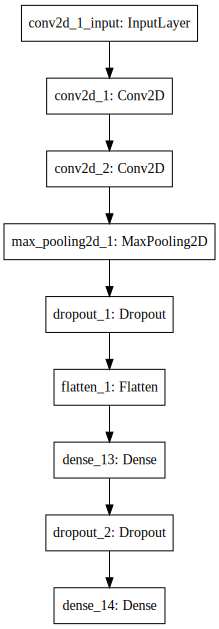

In [33]:
SVG(model_to_dot(model_3).create(prog='dot', format='svg'))

In [34]:
model_3.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [35]:
model_3.fit(predictors, target, epochs=20)

Epoch 1/20
300/300 [==============================] - 4s 12ms/step - loss: 1.1697 - acc: 0.3767
Epoch 2/20
300/300 [==============================] - 3s 11ms/step - loss: 1.0677 - acc: 0.4400

We obtain a **way better** accuracy than the previous model. The computing time on CPU is, of course, starting to get longer with the chosen topology. We can now compare the results on the test set again:

In [36]:
# Reformat the input of the test set
predictors_test = X_test.reshape(X_test.shape[0], 72, 72, 1)
predictors_test /= np.max(X_test)

In [37]:
model_3.evaluate(predictors_test, Y_test)

300/300 [==============================] - 2s 6ms/step


[0.6223523426055908, 0.77666666587193811]

We can confirm on the **test set** as well than the **convolutional network outperforms the MLP**.

### A Regression Problem

We now want to predict the image locations of the vertices of a triangle, given an image of this
triangle. We use the previously define dataset generation function:

In [210]:
[X_train, Y_train] = generate_dataset_regression(300, 20)

**This dataset is a bit different** from the previous ones. X_train is still a set of images, but **Y is not a category of shape**:

In [211]:
print(Y_train.shape)
print(pd.DataFrame(Y_train).head(3))

(300, 6)
          0         1         2         3         4         5
0  0.274999  0.221004  0.318593  0.427006  0.330349  0.141846
1  0.994580  0.604424  0.247091  0.629800  0.550548  0.618729
2  0.106994  0.671484  0.981368  0.615218  0.980321  0.027610


Here, the **Y is composed of 6 values, representing the coordinates of our vertices** following the schema: *x1, y1, x2, y2, x3, y3*. This is, of course, what our model has to predict from the images.
<br>
We also can use the function *visualize_prediction* to observe an X image and its Y polygon:

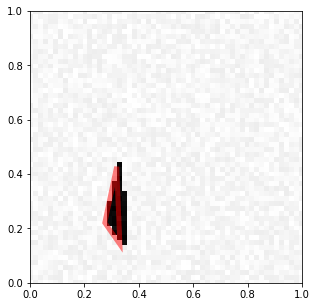

In [212]:
visualize_prediction(X_train[0], Y_train[0])

We change our Y variable to actual points on images:

In [213]:
# Format of the target
Y_train_72 = Y_train*71 + 1
points = []
i=0
for row in Y_train_72:
    points.append(sorted([int(round(5184 - (row[1]-1)*72 - (72-row[0]))),
              int(round(5184 - (row[3]-1)*72 - (72-row[2]))),
              int(round(5184 - (row[5]-1)*72 - (72-row[4])))]))
#vertices = []
#for row in points:
#    vector = np.zeros(5184)
#    for point in row:
#        vector[point - 1] = 1
#    vertices.append(vector)

In [214]:
# Reformat the input of the test set
predictors = X_train.reshape(X_train.shape[0], 72, 72, 1)
predictors /= np.max(X_train)

In [215]:
model_3 = Sequential()

model_3.add(Conv2D(16, (5,5), activation='relu', input_shape=(72, 72, 1)))
model_3.add(Conv2D(16, (5,5), activation='relu'))
model_3.add(MaxPooling2D(pool_size=(2, 2))) 
model_3.add(Dropout(0.25))
model_3.add(Flatten())
model_3.add(Dense(50, activation='relu'))
model_3.add(Dropout(0.5))
model_3.add(Dense(3))

In [216]:
model_3.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])

In [217]:
model_3.fit(predictors, pd.DataFrame(points), epochs=20)

Epoch 1/20
300/300 [==============================] - 4s 14ms/step - loss: 8691462.8867 - acc: 0.4433
Epoch 2/20
300/300 [==============================] - 3s 11ms/step - loss: 5976995.9067 - acc: 0.3833

In [218]:
[X_test, Y_test] =  generate_dataset_regression(300, 20)

In [219]:
# Reformat the input of the test set
predictors_test = X_test.reshape(X_test.shape[0], 72, 72, 1)
predictors_test /= np.max(X_test)

In [220]:
Y_test_72 = Y_test*71 + 1
points_test = []
i=0
for row in Y_test_72:
    points_test.append(sorted([int(round(5184 - (row[1]-1)*72 - (72-row[0]))),
              int(round(5184 - (row[3]-1)*72 - (72-row[2]))),
              int(round(5184 - (row[5]-1)*72 - (72-row[4])))]))

In [243]:
model_3.evaluate(predictors_test, pd.DataFrame(points_test))

300/300 [==============================] - 2s 5ms/step


[1082637.9716666667, 1.0]